# Clasificador Hombre / Mujer

En este notebook implementamos un modelo para clasificar las fotos faciales en las categorias Hombre o Mujer. Para esto utilizamos la tecnica llamada Transfer Learning. reutilizamos un modelo pre-entrenado para clasificar imágenes y lo adaptamos a nuestro objetivo.

# 1. Importación de librerias útiles y de los datos

Primero importamos librerías típicas para el análisis de datos (numpy, pandas...) y creamos una función para guardar las imágenes.

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import Imputer

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
import squarify
from numpy import array
from matplotlib import cm

import datetime

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 2. Training dataset

Para empezar, creamos nuestro dataset de entrenamiento. Tomamos 10000 imágenes, 5000 de cada una de nuestras categorias. 

In [7]:
import pandas as pd
data_wiki = pd.read_csv("./datasets/data_wiki_clean.csv", parse_dates=['birthdate'])

In [8]:
print(data_wiki[data_wiki['gender']==0].shape,data_wiki[data_wiki['gender']==1].shape)

(11979, 13) (39439, 13)


In [9]:
#data_female = data_wiki[data_wiki['gender']==0]
#data_male = data_wiki[data_wiki['gender']==1].sample(n=data_wiki[data_wiki['gender']==0].shape[0])

data_female = data_wiki[data_wiki['gender']==0].sample(n=5000)
data_male = data_wiki[data_wiki['gender']==1].sample(n=5000)


In [10]:
data = pd.concat([data_male, data_female])

In [11]:
data.shape

(10000, 13)

In [12]:
data['gender'].mean()

0.5

In [9]:
data

full_path  gender  \
49731  ./datasets/wiki/15/26913715_1987-02-01_2013.jpg     1.0   
15665  ./datasets/wiki/78/40307178_1999-01-25_2013.jpg     1.0   
24508  ./datasets/wiki/46/37405846_1977-10-30_2015.jpg     1.0   
32074  ./datasets/wiki/75/12661775_1986-04-16_2014.jpg     1.0   
36194  ./datasets/wiki/24/30713124_1985-07-12_2012.jpg     1.0   
22842   ./datasets/wiki/76/1447376_1955-10-01_2013.jpg     1.0   
15416   ./datasets/wiki/37/1036137_1981-10-16_2015.jpg     1.0   
29148  ./datasets/wiki/07/26521107_1925-12-07_1966.jpg     1.0   
34223  ./datasets/wiki/57/26646657_1977-01-04_2011.jpg     1.0   
27731  ./datasets/wiki/63/33532663_1915-08-01_1997.jpg     1.0   
23672  ./datasets/wiki/02/45442302_1993-05-05_2014.jpg     1.0   
22928  ./datasets/wiki/81/24422581_1990-01-02_2013.jpg     1.0   
24721   ./datasets/wiki/73/8743173_1960-03-11_2006.jpg     1.0   
27204  ./datasets/wiki/28/32528528_1932-11-29_1998.jpg     1.0   
16618  ./datasets/wiki/94/22302994_1991-04-20_2012.jpg     1.0   
40314   ./datasets/wiki/31/5778231_1963-02-07_2007.jpg     1.0   
43200   ./datasets/wiki/82/2385482_1979-01-19_2005.jpg     1.0   
42622  ./datasets/wiki/48/22823848_1947-12-25_1974.jpg     1.0   
44494   ./datasets/wiki/37/1683037_1912-04-01_1951.jpg     1.0   
4423   ./datasets/wiki/90/28017190_1990-03-07_2015.jpg     1.0   
25404  ./datasets/wiki/75/29460175_1964-09-18_1983.jpg     1.0   
685      ./datasets/wiki/52/210052_1944-04-15_1980.jpg     1.0   
2076   ./datasets/wiki/92/33078392_1992-05-14_2014.jpg     1.0   
2154    ./datasets/wiki/15/4305615_1976-04-25_2014.jpg     1.0   
3328    ./datasets/wiki/80/9506480_1933-02-17_1965.jpg     1.0   
7558    ./datasets/wiki/91/2416191_1909-06-15_1950.jpg     1.0   
5070     ./datasets/wiki/08/590008_1953-11-11_1980.jpg     1.0   
32520   ./datasets/wiki/73/9262373_1985-06-22_2008.jpg     1.0   
47842    ./datasets/wiki/05/329705_1925-08-28_1952.jpg     1.0   
39816    ./datasets/wiki/08/467808_1958-09-14_2009.jpg     1.0   
...                                                ...     ...   
13076  ./datasets/wiki/45/15247045_1991-08-27_2011.jpg     0.0   
11387   ./datasets/wiki/08/1223608_1957-02-28_2007.jpg     0.0   
30361   ./datasets/wiki/26/7857926_1988-09-19_2011.jpg     0.0   
28019    ./datasets/wiki/66/145366_1932-12-28_2013.jpg     0.0   
13027  ./datasets/wiki/01/15208001_1981-02-08_2012.jpg     0.0   
12719  ./datasets/wiki/17/24261917_1944-09-13_1966.jpg     0.0   
15668  ./datasets/wiki/57/40309357_1960-06-14_2005.jpg     0.0   
36400     ./datasets/wiki/58/50758_1909-02-09_1941.jpg     0.0   
44269  ./datasets/wiki/76/35826676_1994-12-23_2011.jpg     0.0   
50570   ./datasets/wiki/09/1891009_1966-10-03_2009.jpg     0.0   
11521   ./datasets/wiki/89/1229889_1930-11-11_2012.jpg     0.0   
23497  ./datasets/wiki/96/25468896_1993-10-18_2014.jpg     0.0   
5671     ./datasets/wiki/22/801822_1957-05-25_2014.jpg     0.0   
36528  ./datasets/wiki/08/11723308_1980-07-03_2012.jpg     0.0   
14916   ./datasets/wiki/69/7828469_1984-08-17_2009.jpg     0.0   
49584   ./datasets/wiki/21/7596021_1932-05-22_1960.jpg     0.0   
37733  ./datasets/wiki/20/13725520_1986-05-08_2011.jpg     0.0   
43436    ./datasets/wiki/07/538207_1953-07-29_2008.jpg     0.0   
40228  ./datasets/wiki/25/37782325_1955-01-19_1975.jpg     0.0   
29307  ./datasets/wiki/54/36558054_1980-03-28_2012.jpg     0.0   
34583    ./datasets/wiki/18/766618_1989-03-25_2007.jpg     0.0   
12444   ./datasets/wiki/08/7326708_1941-09-15_1966.jpg     0.0   
14520  ./datasets/wiki/65/18224865_1989-03-28_2007.jpg     0.0   
5479   ./datasets/wiki/30/30171530_1970-11-26_2012.jpg     0.0   
26080   ./datasets/wiki/37/4052237_1948-03-08_1967.jpg     0.0   
21317  ./datasets/wiki/27/31419527_1931-03-02_2011.jpg     0.0   
20878  ./datasets/wiki/45/40460245_1991-05-26_2011.jpg     0.0   
44130    ./datasets/wiki/91/158991_1937-08-06_2010.jpg     0.0   
30560  ./datasets/wiki/77/29547777_1984-11-14_2011.jpg     0.0   
22292   ./datasets/

In [10]:
data[data['full_path_crop']=='./datasets/wiki_crop/85/37461485_1942-07-28_1999.jpg']

full_path  gender  \
24551  ./datasets/wiki/85/37461485_1942-07-28_1999.jpg     1.0   

                  name  photo_taken  \
24551  u'Craig Vetter'         1999   

                                          full_path_crop  birthdate  \
24551  ./datasets/wiki_crop/85/37461485_1942-07-28_19... 1942-07-28   

       year_birth  month_birth  weekday_birth  day_birth   age  filesize  \
24551      1942.0          7.0            1.0       28.0  57.0     38199   

       filesize_crop  
24551           5743

# 2. Inception

## 3.1 Inception classification

El modelo pre-entrenado que utilizaremos es Inception, que esta entrenado en imágenes de tamaño 299x299. Este clasificador identifica imágenes en más de 1000 clases (ver competencia ImageNet).

En un primer lugar vamos a descargar el modelo y utilizarlo en nuestras imágenes. Para esto tenemos que preprocesar nuestras fotos para que puedan ser analizadas por el modelo Inception:

Write a preprocessing step that will resize and crop the image to 299 × 299, with some randomness for data augmentation. Agreagamos una funcionalidad de formateo de las imagenes que nos servirá para aumentar el dataset de entrenamiento agregando zoom, crop y flips aleatorios antes de adaptar el tamaño de la imagen a 299x299.

First, let's implement this using NumPy and SciPy:

   - using basic NumPy slicing for image cropping,
   - NumPy's fliplr() function to flip the image horizontally (with 50% probability),
   - and SciPy's imresize() function for zooming.
       - Note that imresize() is based on the Python Image Library (PIL).

For more image manipulation functions, such as rotations, check out SciPy's documentation or this nice page.

In [13]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2, training = True):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    if(training):
        # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
        # between 1.0 and 1.0 + `max_zoom`.
        resize_factor = np.random.rand() * max_zoom + 1.0
        crop_width = int(crop_width / resize_factor)
        crop_height = int(crop_height / resize_factor)
    
        # Next, we can select a random location on the image for this bounding box.
        x0 = np.random.randint(0, width - crop_width)
        y0 = np.random.randint(0, height - crop_height)
        x1 = x0 + crop_width
        y1 = y0 + crop_height
    
        # Let's crop the image using the random bounding box we built.
        image = image[y0:y1, x0:x1]

        # Let's also flip the image horizontally with 50% probability:
        if np.random.rand() < 0.5:
            image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255

In [14]:
width = 299
height = 299
channels = 3

./datasets/wiki_crop/15/26913715_1987-02-01_2013.jpg


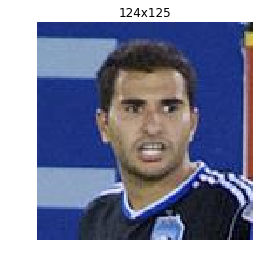

In [15]:
import matplotlib.image as mpimg
#filename = data_wiki['full_path_crop'][160]
filename = data['full_path_crop'][49731]
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



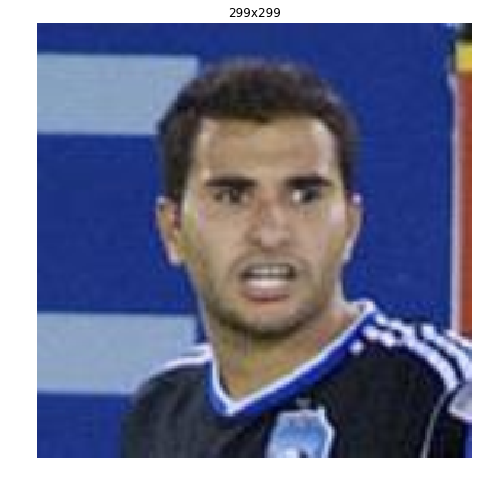

In [16]:
prepared_image = prepare_image(test_image, training = False)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Las imagenes de entrada a Imagenet estan normalizadas tal que el valor de los pixeles se encuentra en [-1,1]. Tenemos que ponderar nuestros pixeles:

In [15]:
prepared_image = 2 * prepared_image - 1

In [16]:
prepared_image.shape

(299, 299, 3)

Download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.

In [17]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [21]:
fetch_pretrained_inception_v3()

In [22]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [23]:
class_names = ["background"] + load_class_names()

In [24]:
class_names[:5]

[u'background',
 u'tench, Tinca tinca',
 u'goldfish, Carassius auratus',
 u'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 u'tiger shark, Galeocerdo cuvieri']

Create the Inception v3 model by calling the inception_v3() function, as shown below. This must be done within an argument scope created by the inception_v3_arg_scope() function. Also, you must set is_training=False and num_classes=1001 [...]

In [25]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, channels], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

 Open a session and use the Saver to restore the pretrained model checkpoint you downloaded earlier.

In [26]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Run the model to classify the images you prepared. Display the top five predictions for each image, along with the estimated probability (the list of class names is available at https://goo.gl/brXRtZ). How accurate is the model?

In [24]:
X_test = prepared_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [25]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

863

In [26]:
class_names[most_likely_class_index]

u'torch'

In [27]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

torch: 17.14%
academic gown, academic robe, judge's robe: 9.31%
racket, racquet: 8.44%
bearskin, busby, shako: 6.62%
mortarboard: 5.22%


## 3.2. Transfer learning 

Creamos nuestro nuevo Target:

In [27]:
gender_classes = ['Female','Male']
gender_classes

[u'Female', u'Male']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



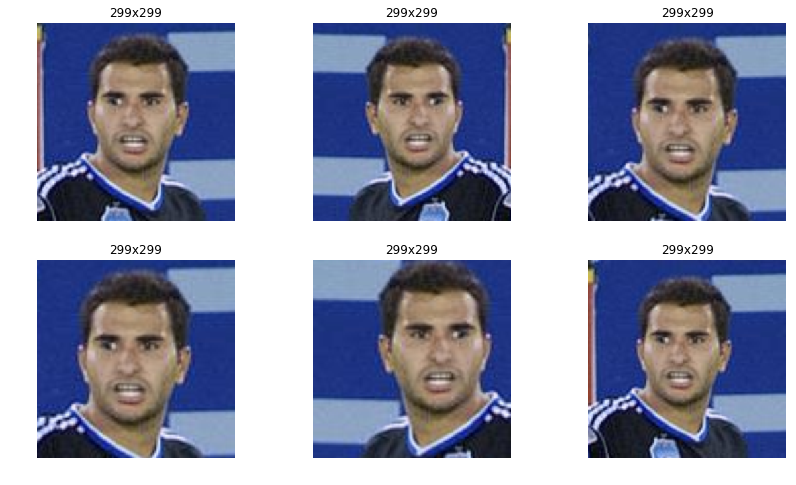

In [25]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(test_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Looks good!

Alternatively, it's also possible to implement this image preprocessing step directly with TensorFlow, using the functions in the tf.image module (see the API for the full list). As you can see, this function looks very much like the one above, except it does not actually perform the image transformation, but rather creates a set of TensorFlow operations that will perform the transformation when you run the graph.

Using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).

Let's start by fetching the inception v3 graph again. This time, let's use a training placeholder that we will use to tell TensorFlow whether we are training the network or not (this is needed by operations such as dropout and batch normalization).


In [28]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

Now we need to find the point in the graph where we should attach the new output layer. It should be the layer right before the current output layer. One way to do this is to explore the output layer's inputs:

In [29]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

Nope, that's part of the output layer (adding the biases). Let's continue walking backwards in the graph:

In [30]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

That's also part of the output layer, it's the final layer in the inception layer (if you are not sure you can visualize the graph using TensorBoard). Once again, let's continue walking backwards in the graph:

In [31]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon. Note that there was actually a simpler way to find this layer: the inception_v3() function returns a dict of end points:

In [32]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [33]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the tf.squeeze() function:


In [34]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer:

In [35]:
n_outputs = len(gender_classes)

with tf.name_scope("new_output_layer"):
    gender_logits = tf.layers.dense(prelogits, n_outputs, name="gender_logits")
    Y_proba = tf.nn.softmax(gender_logits, name="Y_proba")

Finally, we need to add the usual bits and pieces:

   - the placeholder for the targets (y),
   - the loss function, which is the cross-entropy, as usual for a classification task,
   - an optimizer, that we use to create a training operation that will minimize the cost function,
   - a couple operations to measure the model's accuracy,
   - and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's minimize() method:


In [36]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=gender_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    gender_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="gender_logits")
    training_op = optimizer.minimize(loss, var_list=gender_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(gender_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [37]:
[v.name for v in gender_vars]

[u'gender_logits/kernel:0', u'gender_logits/bias:0']

Notice that we created the inception_saver before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second saver will be used to save the final gender model, including both the pretrained variables and the new ones.

Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.

First, we will want to represent the classes as ints rather than strings:

In [38]:
gender_class_ids = {gender_class: index for index, gender_class in enumerate(gender_classes)}
gender_class_ids

{u'Female': 0, u'Male': 1}

It will be easier to shuffle the dataset set if we represent it as a list of filepath/class pairs:

In [39]:
from collections import defaultdict

image_paths = defaultdict(list)

for gender_class in gender_class_ids:
    print(gender_class,gender_class_ids[gender_class])
    for i,p in enumerate(data[data['gender']==gender_class_ids[gender_class]]['full_path_crop']):
        image_paths[gender_class].append(p)


Male 1
Female 0


In [40]:
gender_paths_and_classes = []
for gender_class, paths in image_paths.items():
    for path in paths:
        gender_paths_and_classes.append((path, gender_class_ids[gender_class]))

In [41]:
len(gender_paths_and_classes)

10000

Next, lets shuffle the dataset and split it into the training set and the test set:

In [40]:
test_ratio = 0.2
train_size = int(len(gender_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(gender_paths_and_classes)

gender_paths_and_classes_train = gender_paths_and_classes[:train_size]
gender_paths_and_classes_test = gender_paths_and_classes[train_size:]

In [41]:
print(len(gender_paths_and_classes_train),len(gender_paths_and_classes_test))

8000 2000


Let's look at the first 3 instances in the training set:

In [42]:
gender_paths_and_classes_train[:3]

[('./datasets/wiki_crop/96/22368896_1971-04-29_2005.jpg', 0),
 ('./datasets/wiki_crop/03/35062103_1989-02-21_2011.jpg', 1),
 ('./datasets/wiki_crop/57/15729157_1982-08-20_2009.jpg', 1)]

In [43]:
gender_paths_and_classes[:3]

[('./datasets/wiki_crop/96/22368896_1971-04-29_2005.jpg', 0),
 ('./datasets/wiki_crop/03/35062103_1989-02-21_2011.jpg', 1),
 ('./datasets/wiki_crop/57/15729157_1982-08-20_2009.jpg', 1)]

Next, we will also need a function to preprocess a set of images. This function will be useful to preprocess the test set, and also to create batches during training. For simplicity, we will use the NumPy/SciPy implementation:

In [44]:
from random import sample

def prepare_batch(gender_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(gender_paths_and_classes, batch_size)
    images = []
    y =[]
    for path, labels in batch_paths_and_classes:
        if(len(mpimg.imread(path).shape)>2):
            images.append(mpimg.imread(path)[:, :, :channels])
            y.append(labels)
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array(y, dtype=np.int32)
    return X_batch, y_batch

def prepare_batch_paths(gender_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(gender_paths_and_classes, batch_size)
    images = []
    y =[]
    paths_batch = []
    for path, labels in batch_paths_and_classes:
        if(len(mpimg.imread(path).shape)>2):
            images.append(mpimg.imread(path)[:, :, :channels])
            y.append(labels)
            paths_batch.append(path)
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array(y, dtype=np.int32)
    return X_batch, y_batch, paths_batch


In [47]:
X_batch, y_batch, paths_batch = prepare_batch_paths(gender_paths_and_classes, batch_size=6)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



In [48]:
X_batch.shape

(6, 299, 299, 3)

In [49]:
X_batch.dtype

dtype('float32')

In [50]:
y_batch.shape

(6,)

In [51]:
y_batch.dtype

dtype('int32')

In [52]:
paths_batch

['./datasets/wiki_crop/85/45005785_1910-01-12_1942.jpg',
 './datasets/wiki_crop/93/18750993_1949-07-01_2009.jpg',
 './datasets/wiki_crop/04/1468604_1928-07-14_1950.jpg',
 './datasets/wiki_crop/45/37874745_1992-05-01_2014.jpg',
 './datasets/wiki_crop/88/7180588_1987-06-23_2009.jpg',
 './datasets/wiki_crop/43/174843_1947-11-14_2006.jpg']

Looking good. Now let's use this function to prepare the test set:

In [53]:
X_test, y_test, paths_test = prepare_batch_paths(gender_paths_and_classes_test, batch_size=len(gender_paths_and_classes_test))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



In [54]:
X_test.shape

(1805, 299, 299, 3)

In [55]:
y_test.shape

(1805,)

In [56]:
len(paths_test)

1805

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.


In [60]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(gender_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(gender_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_genders_modelXXX")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



.......................................................................................................................................................................................................  Train accuracy: 0.71428573
Epoch 1........................................................................................................................................................................................................  Train accuracy: 0.7837838
Epoch 2........................................................................................................................................................................................................  Train accuracy: 0.75757575
Epoch 3........................................................................................................................................................................................................  Train accuracy: 0.7105263
Epoch 4...........................................................

In [57]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)
paths_test_batches = np.array_split(paths_test, n_test_batches)

In [58]:
X_test.shape

(1805, 299, 299, 3)

In [63]:
with tf.Session() as sess:
    saver.restore(sess, "./my_genders_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_genders_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.82439536


In [64]:
acc_test

0.82439536

## 3.3 Test on custom images:

In [65]:
data['full_path_crop']

49731    ./datasets/wiki_crop/15/26913715_1987-02-01_20...
15665    ./datasets/wiki_crop/78/40307178_1999-01-25_20...
24508    ./datasets/wiki_crop/46/37405846_1977-10-30_20...
32074    ./datasets/wiki_crop/75/12661775_1986-04-16_20...
36194    ./datasets/wiki_crop/24/30713124_1985-07-12_20...
22842    ./datasets/wiki_crop/76/1447376_1955-10-01_201...
15416    ./datasets/wiki_crop/37/1036137_1981-10-16_201...
29148    ./datasets/wiki_crop/07/26521107_1925-12-07_19...
34223    ./datasets/wiki_crop/57/26646657_1977-01-04_20...
27731    ./datasets/wiki_crop/63/33532663_1915-08-01_19...
23672    ./datasets/wiki_crop/02/45442302_1993-05-05_20...
22928    ./datasets/wiki_crop/81/24422581_1990-01-02_20...
24721    ./datasets/wiki_crop/73/8743173_1960-03-11_200...
27204    ./datasets/wiki_crop/28/32528528_1932-11-29_19...
16618    ./datasets/wiki_crop/94/22302994_1991-04-20_20...
40314    ./datasets/wiki_crop/31/5778231_1963-02-07_200...
43200    ./datasets/wiki_crop/82/2385482_1979-01-19_200.

./datasets/test.jpeg


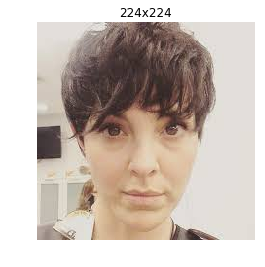

In [60]:
import matplotlib.image as mpimg
#filename = data_wiki['full_path_crop'][160]
#filename = data['full_path_crop'][49731]
#filename = './datasets/wiki_crop/62/38984162_1997-10-20_2015.jpg'
#filename = './datasets/ChaLearn/train/000434.jpg'
#filename = './datasets/ChaLearn/train/000432.jpg'
filename = "./datasets/test.jpeg"
#filename = "./datasets/and.jpeg"
#filename = "./datasets/elodie.jpeg"
#filename = "./datasets/ivo.jpeg"
#filename = "./datasets/and2.jpeg"
#filename = "./datasets/bebe.jpg"
#filename = "./datasets/conchita.jpeg"
#filename = "./datasets/conchita2.jpeg"
#filename = "./datasets/barba.jpeg"
#filename = "./datasets/yacine.jpeg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



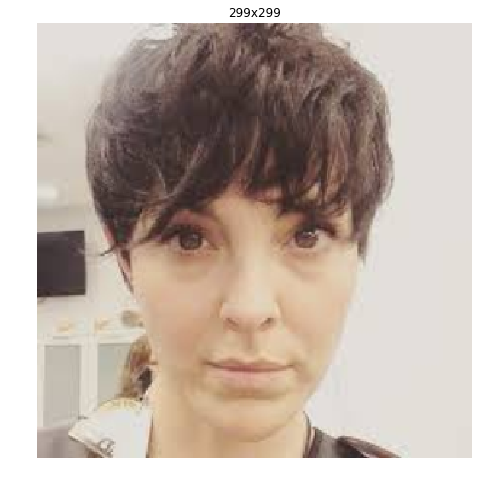

In [61]:
prepared_image = prepare_image(test_image, training = False)
plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

In [62]:
prepared_image = 2 * prepared_image - 1
X_test_im = prepared_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, "./my_genders_model")
    predictions = sess.run(Y_proba, feed_dict={X: X_test_im})
    #predictions_val = accuracy.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_genders_model


In [63]:
most_likely_class_index = np.argmax(predictions[0])
most_likely_class_index

1

In [64]:
top = np.argpartition(predictions[0], -2)[-2:]
top = reversed(top[np.argsort(predictions[0][top])])
for i in top:
    print("{0}: {1:.2f}%".format(gender_classes[i], 100 * predictions[0][i]))

Male: 60.81%
Female: 39.19%


## 3.4 See some photos labeled incorrectly:

In [71]:
len(y_test_batches[0])

181

In [72]:
X_test_batches[0].shape

(181, 299, 299, 3)

In [80]:
predictions_test_batch = []
with tf.Session() as sess:
    saver.restore(sess, "./my_genders_model")
    for X_test_i in X_test_batches[0]:
        prepared_image = prepare_image(X_test_i, training = False)
        prepared_image = 2 * prepared_image - 1
        prepared_image = prepared_image.reshape(-1, height, width, channels)
        predictions_test_batch.append(sess.run(Y_proba, feed_dict={X: prepared_image}))

INFO:tensorflow:Restoring parameters from ./my_genders_model


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



In [81]:
c=0
for i in range(len(y_test_batches[0])):
    #print(predictions_test_batch[i],y_test_batches[0][i],paths_test_batches[0][i])
    print(np.argmax(predictions_test_batch[i]),
          y_test_batches[0][i], 
          np.argmax(predictions_test_batch[i])== y_test_batches[0][i],
          paths_test_batches[0][i])
          #paths_test_batches)
    if (np.argmax(predictions_test_batch[i])== y_test_batches[0][i]):c+=1
print(c/len(predictions_test_batch))

0 0 True ./datasets/wiki_crop/34/5007334_1985-05-02_2007.jpg
0 1 False ./datasets/wiki_crop/82/8855682_1975-04-18_2015.jpg
1 0 False ./datasets/wiki_crop/97/35032797_1986-08-15_2014.jpg
1 1 True ./datasets/wiki_crop/58/743658_1939-06-09_2005.jpg
0 0 True ./datasets/wiki_crop/27/39366727_1990-06-06_2012.jpg
1 1 True ./datasets/wiki_crop/06/293306_1972-04-15_2013.jpg
1 1 True ./datasets/wiki_crop/24/20642624_1943-10-26_2008.jpg
1 1 True ./datasets/wiki_crop/62/35484762_1963-03-27_2013.jpg
0 0 True ./datasets/wiki_crop/64/5737964_1980-07-16_2007.jpg
1 1 True ./datasets/wiki_crop/38/14091638_1937-11-28_1975.jpg
0 0 True ./datasets/wiki_crop/09/1891009_1966-10-03_2009.jpg
1 0 False ./datasets/wiki_crop/06/37409106_1988-02-21_2013.jpg
0 0 True ./datasets/wiki_crop/91/17652091_1952-05-02_1994.jpg
1 0 False ./datasets/wiki_crop/30/21038430_1991-12-15_2009.jpg
0 0 True ./datasets/wiki_crop/69/2489569_1958-01-29_1977.jpg
1 1 True ./datasets/wiki_crop/38/5211038_1963-03-01_2009.jpg
1 1 True ./dat

### True Male predicted as Female

./datasets/wiki_crop/82/8855682_1975-04-18_2015.jpg


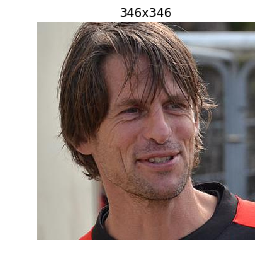

In [83]:
filename = "./datasets/wiki_crop/82/8855682_1975-04-18_2015.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

./datasets/wiki_crop/85/37461485_1942-07-28_1999.jpg


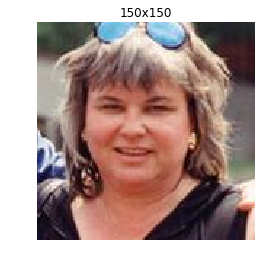

In [86]:
filename = "./datasets/wiki_crop/85/37461485_1942-07-28_1999.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

./datasets/wiki_crop/17/3905117_1978-10-06_2004.jpg


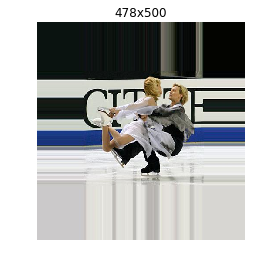

In [91]:
filename = "./datasets/wiki_crop/17/3905117_1978-10-06_2004.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

### True Female predicted as Male

./datasets/wiki_crop/30/21038430_1991-12-15_2009.jpg


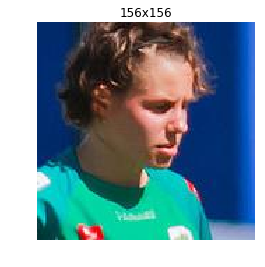

In [92]:
#Female id as male
filename = "./datasets/wiki_crop/30/21038430_1991-12-15_2009.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

./datasets/wiki_crop/04/282404_1936-07-14_2007.jpg


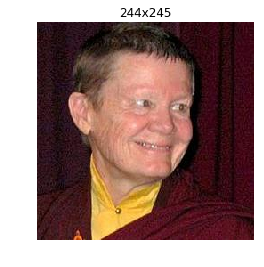

In [95]:
filename = "./datasets/wiki_crop/04/282404_1936-07-14_2007.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

./datasets/wiki_crop/22/3528822_1980-01-29_2009.jpg


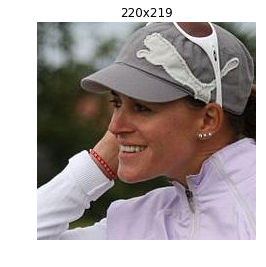

In [96]:
filename = "./datasets/wiki_crop/22/3528822_1980-01-29_2009.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

./datasets/wiki_crop/94/32296594_1996-04-24_2013.jpg


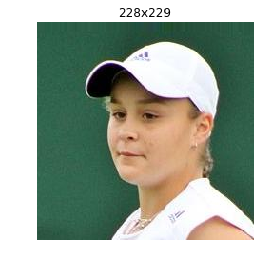

In [185]:
filename = "./datasets/wiki_crop/94/32296594_1996-04-24_2013.jpg"
test_image = mpimg.imread(filename)[:, :, :channels]
print(filename)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.imshow(test_image)
plt.axis("off")
plt.show()

## 3.5 Matriz de confusión

In [64]:
y_test_batches

[array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1], dtype=int32),
 array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,


In [65]:
predictions_test = []
with tf.Session() as sess:
    saver.restore(sess, "./my_genders_model")
    for batch in range(len(X_test_batches)):
        for X_test_i in X_test_batches[batch]:
            prepared_image = prepare_image(X_test_i, training = False)
            prepared_image = 2 * prepared_image - 1
            prepared_image = prepared_image.reshape(-1, height, width, channels)
            predictions_test.append(sess.run(Y_proba, feed_dict={X: prepared_image}))

INFO:tensorflow:Restoring parameters from ./my_genders_model


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



In [66]:
predict = [np.argmax(predictions_test[i]) for i in range(len(predictions_test))]

In [67]:
true = [item for sublist in y_test_batches for item in sublist]

In [88]:
print(len(predict),len(true))

1805 1805


Save to csv to future manipulation without having to rerun model:

In [89]:
gender_true = np.asarray(true)
gender_predict = np.asarray(predict)
np.savetxt("gender_true.csv", gender_true, delimiter=",")
np.savetxt("gender_predict.csv", gender_predict, delimiter=",")

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [71]:
from sklearn.metrics import confusion_matrix
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(true, predict)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[664 250]
 [ 65 826]]
Saving figure 2-gender-confusion-matrix


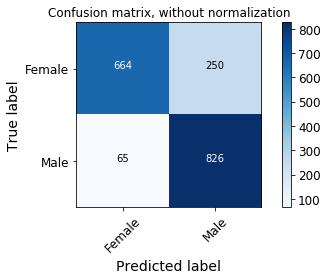

In [75]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=gender_classes,
                      title='Confusion matrix, without normalization')
save_fig("2-gender-confusion-matrix")
plt.show()

Normalized confusion matrix
[[0.73 0.27]
 [0.07 0.93]]
Saving figure 2-gender-confusion-matrix-norm


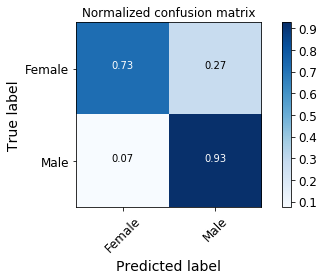

In [74]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=gender_classes, normalize=True,
                      title='Normalized confusion matrix')
save_fig("2-gender-confusion-matrix-norm")
plt.show()

# 4. Mejoras posibles

Tenemos un modelo que nos dice si una iagen corresponde a un hombre o una mujer con 80% de accuracy. No esta mal para un primer entrenamiento con tan solo 10 epochs.

Podemos mejorar nuestro modelo de distintas maneras:

 - Aumentando el numero de epochs
 - Aumentando el dataset de entranemiento : hemos usado solo 10000 imagenes, 8000 para entranar el modelo, 2000 para validarlo. Tenemos a nuestra dispocisión 500000 imágenes, 50 veces mas..
 - Con un GPU podriamos entrenar mas y mas rapido, utilizando early stopping para interrumpir los entrenamientos.
 - Podriamos entonces también tunear mas las imagenes, cambiar el brillo y contraste, hacer rotaciones, etc.
 
